<a href="https://colab.research.google.com/github/shoaibkhanz/my_DataScientist_nanodegree/blob/master/Identify_Customer_Segments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [306]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msn
import re
# magic word for producing visualizations in notebook
%matplotlib inline


### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [0]:
# Load in the general demographics data.
azdias = pd.read_csv('/content/drive/My Drive/DSND/projects/p3_customer_segmentation/Udacity_AZDIAS_Subset.csv',delimiter=';')

# Load in the feature summary file.
feat_info = pd.read_csv('/content/drive/My Drive/DSND/projects/p3_customer_segmentation/AZDIAS_Feature_Summary.csv',delimiter=';')

In [309]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
print(azdias.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
AGER_TYP                 891221 non-null int64
ALTERSKATEGORIE_GROB     891221 non-null int64
ANREDE_KZ                891221 non-null int64
CJT_GESAMTTYP            886367 non-null float64
FINANZ_MINIMALIST        891221 non-null int64
FINANZ_SPARER            891221 non-null int64
FINANZ_VORSORGER         891221 non-null int64
FINANZ_ANLEGER           891221 non-null int64
FINANZ_UNAUFFAELLIGER    891221 non-null int64
FINANZ_HAUSBAUER         891221 non-null int64
FINANZTYP                891221 non-null int64
GEBURTSJAHR              891221 non-null int64
GFK_URLAUBERTYP          886367 non-null float64
GREEN_AVANTGARDE         891221 non-null int64
HEALTH_TYP               891221 non-null int64
LP_LEBENSPHASE_FEIN      886367 non-null float64
LP_LEBENSPHASE_GROB      886367 non-null float64
LP_FAMILIE_FEIN          886367 non-null float64
LP_FAMILIE_GROB          886367 n

In [310]:
azdias.head(3)

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,...,ANZ_TITEL,HH_EINKOMMEN_SCORE,KK_KUNDENTYP,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,4,0,10.0,0,-1,15.0,4.0,2.0,2.0,1.0,1.0,0,0,5.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,-1,NaN,...,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,1,1996,10.0,0,3,21.0,6.0,5.0,3.0,2.0,1.0,1,14,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,3,1.0,...,0.0,6.0,NaN,3.0,9.0,11.0,0.0,8.0,1.0,1992.0,W,4.0,8,8A,51,0.0,0.0,0.0,2.0,5.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,1,1979,10.0,1,3,3.0,1.0,1.0,1.0,3.0,2.0,1,15,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,2,0.0,...,0.0,4.0,NaN,3.0,9.0,10.0,0.0,1.0,5.0,1992.0,W,2.0,4,4C,24,1.0,3.0,1.0,0.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0


In [0]:
feat_info.set_index('attribute',inplace = True)

In [312]:
azdias['CAMEO_DEUG_2015'].value_counts()

8    134441
9    108177
6    105874
4    103912
3     86779
2     83231
7     77933
5     55310
1     36212
X       373
Name: CAMEO_DEUG_2015, dtype: int64

> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [313]:
feat_missing = feat_info['missing_or_unknown'].str.replace(r'(\[|\])','',regex = True)
feat_missing = feat_missing.str.split(',')
feat_missing

attribute
AGER_TYP                    [-1, 0]
ALTERSKATEGORIE_GROB     [-1, 0, 9]
ANREDE_KZ                   [-1, 0]
CJT_GESAMTTYP                   [0]
FINANZ_MINIMALIST              [-1]
FINANZ_SPARER                  [-1]
FINANZ_VORSORGER               [-1]
FINANZ_ANLEGER                 [-1]
FINANZ_UNAUFFAELLIGER          [-1]
FINANZ_HAUSBAUER               [-1]
FINANZTYP                      [-1]
GEBURTSJAHR                     [0]
GFK_URLAUBERTYP                  []
GREEN_AVANTGARDE                 []
HEALTH_TYP                  [-1, 0]
LP_LEBENSPHASE_FEIN             [0]
LP_LEBENSPHASE_GROB             [0]
LP_FAMILIE_FEIN                 [0]
LP_FAMILIE_GROB                 [0]
LP_STATUS_FEIN                  [0]
LP_STATUS_GROB                  [0]
NATIONALITAET_KZ            [-1, 0]
PRAEGENDE_JUGENDJAHRE       [-1, 0]
RETOURTYP_BK_S                  [0]
SEMIO_SOZ                   [-1, 9]
SEMIO_FAM                   [-1, 9]
SEMIO_REL                   [-1, 9]
SEMIO_MAT         

#import pdb
def fill_missing_df(df):
  '''

  input: pandas dataframe
  output: dataset with filled missing values
  
  '''
  for i, col in enumerate(feat_missing.index,0):
    #pdb.set_trace()
    for k in range(0,len(feat_missing[i])):
      if feat_missing[i]==[''] or (feat_missing[i]==['X']) or (feat_missing[i]==['XX']):
        continue
      #elif df[col].dtype =='O':
      #  df.loc[df[col]== feat_missing[i][k],col] = np.nan
      else:  
        df.loc[df[col]== int(feat_missing[i][k]),col] = np.nan
    return df

azdias_ = fill_missing_df(azdias)

In [0]:
def fill_missing_df(df):
  for i,V in enumerate(df.iteritems()):
      missing_unknown = feat_info['missing_or_unknown'][i]
      column_name = V[0]
      missing_unknown = missing_unknown[1:-1].split(',')
      if missing_unknown != ['']:
          hold = []
          for x in missing_unknown:
              if x in ['X','XX']:
                  hold.append(x)
              else:
                  hold.append(int(x))
          df[column_name] = df[column_name].replace(hold,np.nan)
          
  return df
azdias = fill_missing_df(azdias)

In [315]:
# Identify missing or unknown data values and convert them to NaNs.
ismissing = azdias.isnull().sum()
print(ismissing[ismissing != 0],'=='*40)
print(sum(ismissing[ismissing != 0]))

AGER_TYP                 685843
ALTERSKATEGORIE_GROB       2881
CJT_GESAMTTYP              4854
GEBURTSJAHR              392318
GFK_URLAUBERTYP            4854
HEALTH_TYP               111196
LP_LEBENSPHASE_FEIN       97632
LP_LEBENSPHASE_GROB       94572
LP_FAMILIE_FEIN           77792
LP_FAMILIE_GROB           77792
LP_STATUS_FEIN             4854
LP_STATUS_GROB             4854
NATIONALITAET_KZ         108315
PRAEGENDE_JUGENDJAHRE    108164
RETOURTYP_BK_S             4854
SHOPPER_TYP              111196
SOHO_KZ                   73499
TITEL_KZ                 889061
VERS_TYP                 111196
ALTER_HH                 310267
ANZ_PERSONEN              73499
ANZ_TITEL                 73499
HH_EINKOMMEN_SCORE        18348
KK_KUNDENTYP             584612
W_KEIT_KIND_HH           147988
WOHNDAUER_2008            73499
ANZ_HAUSHALTE_AKTIV       99611
ANZ_HH_TITEL              97008
GEBAEUDETYP               93148
KONSUMNAEHE               73969
                          ...  
OST_WEST

In [0]:
ismissing = azdias.isnull().sum()
sum(ismissing[ismissing != 0])
ismissing = ismissing/len(azdias)
ismissing.sort_values(ascending=False,inplace=True)

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

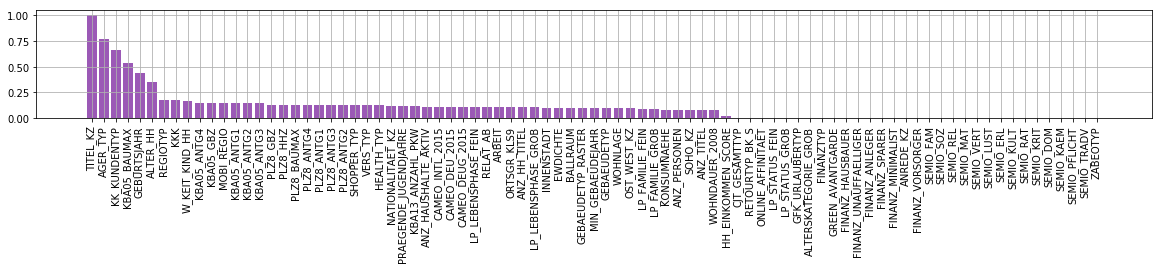

TITEL_KZ                 0.997576
AGER_TYP                 0.769554
KK_KUNDENTYP             0.655967
KBA05_BAUMAX             0.534687
GEBURTSJAHR              0.440203
ALTER_HH                 0.348137
REGIOTYP                 0.177357
KKK                      0.177357
W_KEIT_KIND_HH           0.166051
KBA05_ANTG4              0.149597
KBA05_GBZ                0.149597
MOBI_REGIO               0.149597
KBA05_ANTG1              0.149597
KBA05_ANTG2              0.149597
KBA05_ANTG3              0.149597
PLZ8_GBZ                 0.130736
PLZ8_HHZ                 0.130736
PLZ8_BAUMAX              0.130736
PLZ8_ANTG4               0.130736
PLZ8_ANTG1               0.130736
PLZ8_ANTG3               0.130736
PLZ8_ANTG2               0.130736
SHOPPER_TYP              0.124768
VERS_TYP                 0.124768
HEALTH_TYP               0.124768
NATIONALITAET_KZ         0.121536
PRAEGENDE_JUGENDJAHRE    0.121366
KBA13_ANZAHL_PKW         0.118714
ANZ_HAUSHALTE_AKTIV      0.111769
CAMEO_INTL_201

In [317]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
fig , ax = plt.subplots(figsize=(20,2))
ax.bar(ismissing.index,ismissing.values)
ax.tick_params(axis = 'x',rotation = 90,)
#for i, val in enumerate(ismissing.values):
#  ax.text(val,i,str(np.round(missing.values,0)),color='black')
ax.grid(True)
plt.show()

display(ismissing)

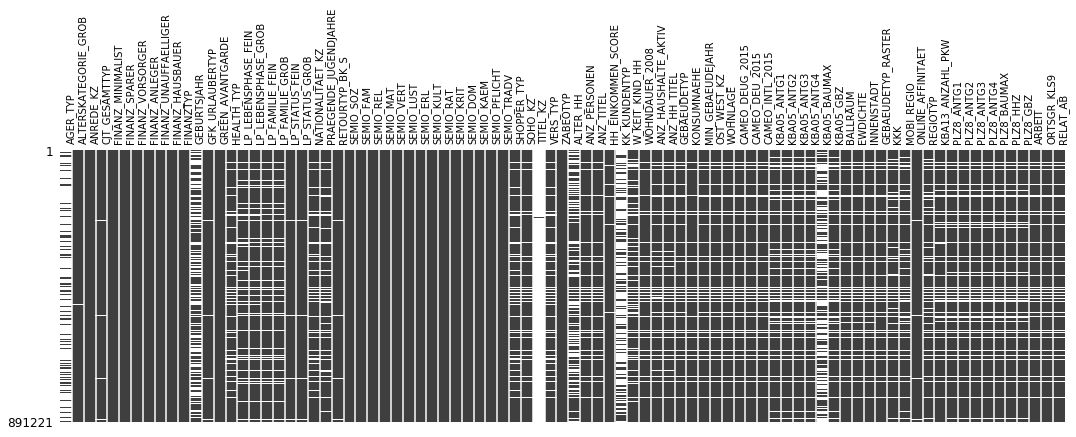

In [318]:
_ = msn.matrix(azdias,labels = True,figsize=(18,5),sparkline = False,fontsize=10)
plt.xticks(rotation = 90)
plt.show()


In [0]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.
keep_cols = ismissing[ismissing < 0.13].index #remove columns with more than 12% missing data
azdias = azdias.loc[:,keep_cols]

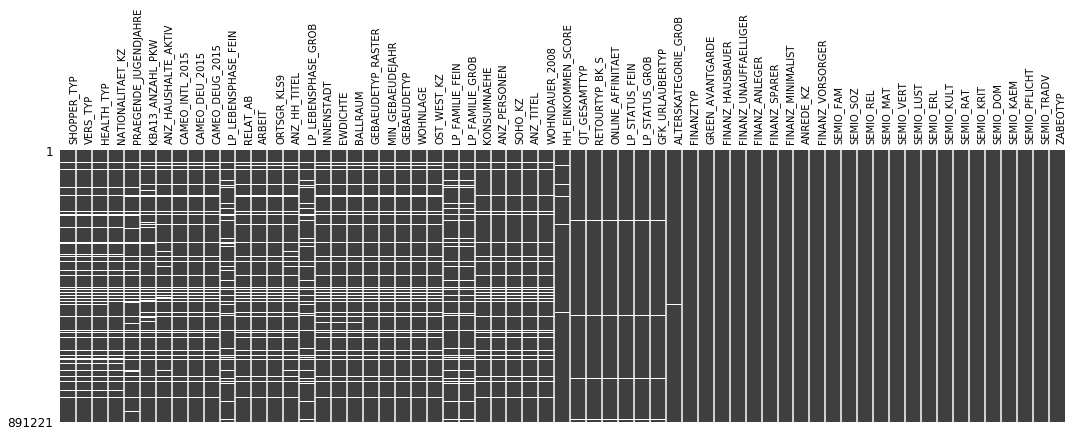

In [320]:
#plt.figure(figsize=(15,6))
_ = msn.matrix(azdias,labels = True,figsize=(18,5),sparkline = False,fontsize=10)
plt.xticks(rotation = 90)
plt.show()


#### Discussion 1.1.2: Assess Missing Data in Each Column

>> We can observe that more than half the columns are missing data, thus we cannot drop all the columns as they may contain some important variables. Thus, If you look carefully at the bar chart above, a 30% cut-off seems like a good threshold, because it takes away the higher peaks of columns but still retains most of the columns. We will have to impute them later on. 

>> Next I have looked at a plot of missing values before and after dropping variables, which not only gives us a view of missing data in each `column` but also helps us to understand `whats missing in the rows`. 

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

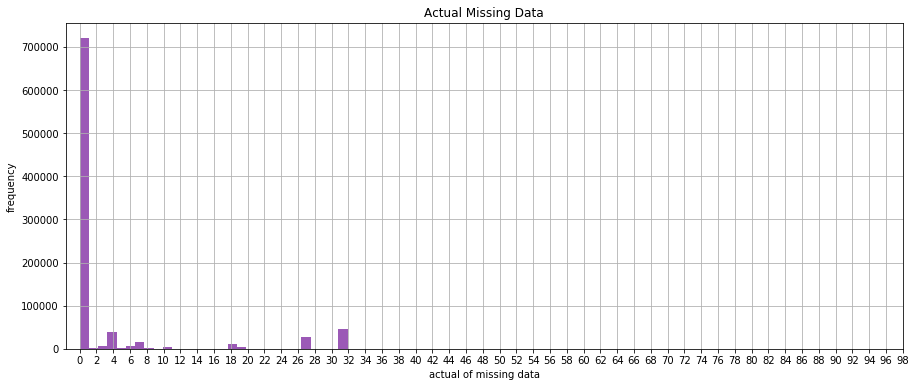

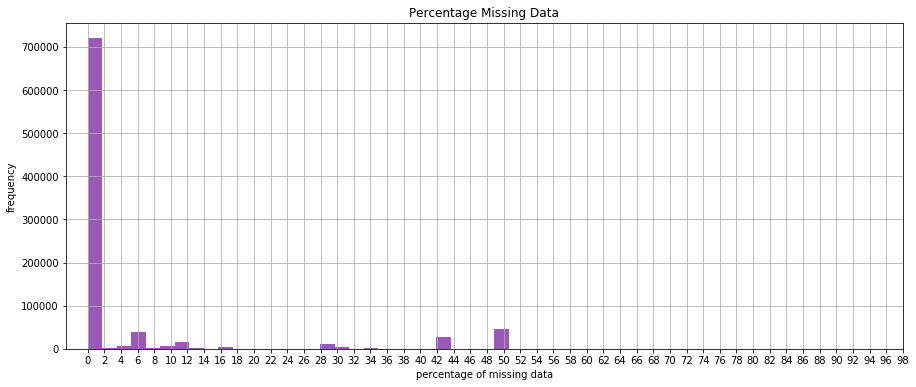

In [321]:
# How much data is missing in each row of the dataset?
missing = azdias.isnull().sum(axis = 1)
missing_perc = (missing/azdias.shape[1])*100

plt.figure(figsize = (15,6))
_ = plt.hist(missing,bins=30)
plt.ylabel('frequency')
plt.xlabel('actual of missing data')
plt.title('Actual Missing Data')
plt.xticks(np.arange(0,100,2))
plt.grid(True)
plt.show()

plt.figure(figsize = (15,6))
_ = plt.hist(missing_perc,bins=30)
plt.ylabel('frequency')
plt.xlabel('percentage of missing data')
plt.title('Percentage Missing Data')
plt.xticks(np.arange(0,100,2))
plt.grid(True)
plt.show()



In [0]:
#4 seems to be a good spot to cut of the data as one can see from the 1st grpah of actual missing data
missing5 = azdias[azdias.isnull().sum(axis = 1) <= 5]

missing5nmore = azdias[azdias.isnull().sum(axis = 1) > 5]

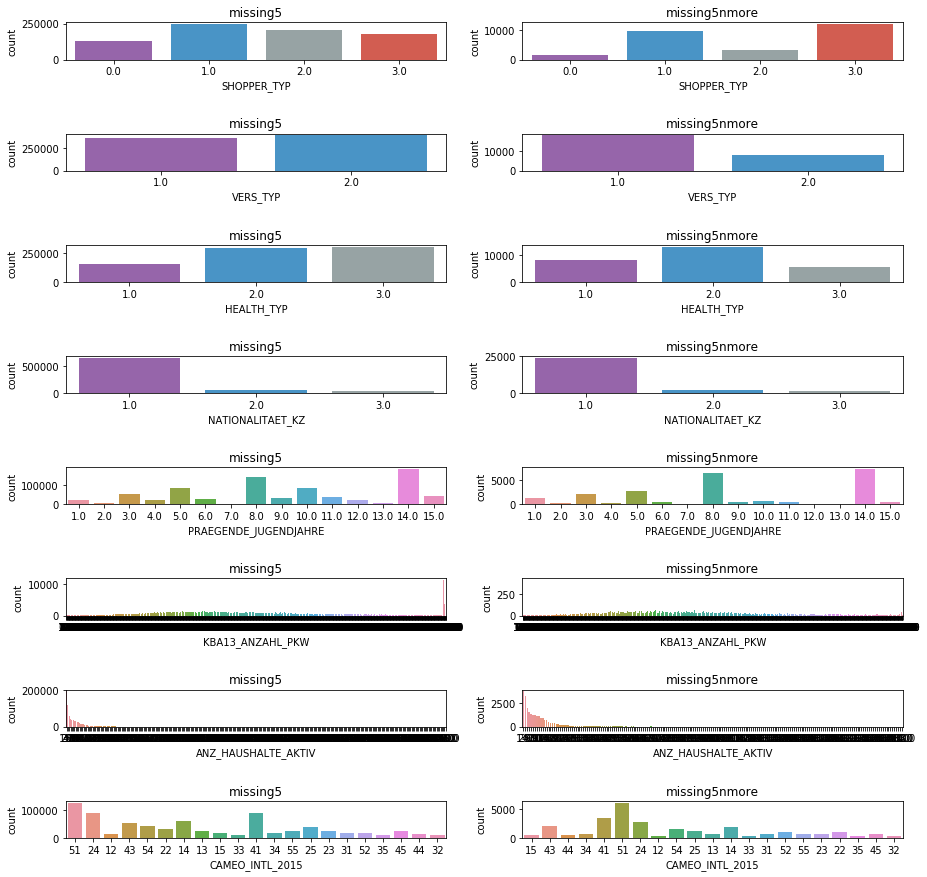

In [323]:
flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
sns.set_palette(flatui)


def countplot(features,n):
    
    fig, axs = plt.subplots(n,2, figsize=(15, 15))
    fig.subplots_adjust(hspace =2 , wspace=.2)
    axs = axs.ravel()

    for i in range(n):
    
        sns.countplot(missing5[features[i]], ax=axs[i*2])
        axs[i*2].set_title('missing5')

        
        sns.countplot(missing5nmore[features[i]], ax=axs[i*2+1])
        axs[i*2+1].set_title('missing5nmore')
    
    
countplot(missing5.columns,8)

In [0]:
full_df = missing5.copy(deep=True)

In [325]:
print('Remaining missing values:missing5 = ',missing5.isnull().sum().sum(),'\n',
      'Remaining missing values:full_df = ',full_df.isnull().sum().sum(),'\n',
      'Remaining missing values:missing5nmore = ', missing5nmore.isnull().sum().sum())

Remaining missing values:missing5 =  209946 
 Remaining missing values:full_df =  209946 
 Remaining missing values:missing5nmore =  2745693


In [326]:
print(full_df.shape)
full_df.head()


(769806, 63)


,SHOPPER_TYP,VERS_TYP,HEALTH_TYP,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,KBA13_ANZAHL_PKW,ANZ_HAUSHALTE_AKTIV,CAMEO_INTL_2015,CAMEO_DEU_2015,CAMEO_DEUG_2015,LP_LEBENSPHASE_FEIN,RELAT_AB,ARBEIT,ORTSGR_KLS9,ANZ_HH_TITEL,LP_LEBENSPHASE_GROB,INNENSTADT,EWDICHTE,BALLRAUM,GEBAEUDETYP_RASTER,MIN_GEBAEUDEJAHR,GEBAEUDETYP,WOHNLAGE,OST_WEST_KZ,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,KONSUMNAEHE,ANZ_PERSONEN,SOHO_KZ,ANZ_TITEL,WOHNDAUER_2008,HH_EINKOMMEN_SCORE,CJT_GESAMTTYP,RETOURTYP_BK_S,ONLINE_AFFINITAET,LP_STATUS_FEIN,LP_STATUS_GROB,GFK_URLAUBERTYP,ALTERSKATEGORIE_GROB,FINANZTYP,GREEN_AVANTGARDE,FINANZ_HAUSBAUER,FINANZ_UNAUFFAELLIGER,FINANZ_ANLEGER,FINANZ_SPARER,FINANZ_MINIMALIST,ANREDE_KZ,FINANZ_VORSORGER,SEMIO_FAM,SEMIO_SOZ,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,ZABEOTYP
1,3.0,2.0,3.0,1.0,14.0,963.0,11.0,51,8A,8,21.0,4.0,3.0,5.0,0.0,6.0,8.0,3.0,6.0,3.0,1992.0,8.0,4.0,W,5.0,3.0,1.0,2.0,1.0,0.0,9.0,6.0,5.0,1.0,3.0,2.0,1.0,10.0,1.0,1,0,5,4,5,5,1,2,2,4,5,4,3,1,2,2,3,6,4,7,4,7,6,5
2,2.0,1.0,3.0,1.0,15.0,712.0,10.0,24,4C,4,3.0,2.0,3.0,5.0,0.0,1.0,4.0,4.0,2.0,4.0,1992.0,1.0,2.0,W,1.0,1.0,5.0,1.0,0.0,0.0,9.0,4.0,3.0,3.0,2.0,3.0,2.0,10.0,3.0,1,1,5,3,2,4,1,2,1,1,4,3,3,4,4,6,3,4,7,7,7,3,3,5
3,1.0,1.0,2.0,1.0,8.0,596.0,1.0,12,2A,2,NaN,3.0,2.0,3.0,0.0,NaN,6.0,2.0,4.0,4.0,1997.0,1.0,7.0,W,NaN,NaN,4.0,0.0,0.0,0.0,9.0,1.0,2.0,2.0,1.0,9.0,4.0,1.0,4.0,6,0,2,1,2,2,4,2,5,1,5,2,1,4,4,7,4,3,4,4,5,4,4,3
4,2.0,2.0,3.0,1.0,8.0,435.0,3.0,43,6B,6,32.0,5.0,4.0,6.0,0.0,10.0,1.0,5.0,2.0,5.0,1992.0,1.0,3.0,W,10.0,5.0,4.0,4.0,0.0,0.0,9.0,5.0,5.0,5.0,5.0,3.0,2.0,5.0,3.0,5,0,2,3,1,3,4,1,4,4,6,4,2,7,4,4,6,2,3,2,2,4,2,4
5,0.0,2.0,3.0,1.0,3.0,1300.0,5.0,54,8C,8,8.0,3.0,2.0,3.0,0.0,2.0,7.0,2.0,6.0,4.0,1992.0,1.0,7.0,W,1.0,1.0,5.0,1.0,0.0,0.0,9.0,5.0,2.0,3.0,1.0,4.0,2.0,1.0,1.0,2,0,5,2,2,1,3,2,5,4,2,7,4,2,2,2,5,7,4,4,4,7,6,4


#### Discussion 1.1.3: Assess Missing Data in Each Row

>> When we look at rows in the histograms of missing data above we can see that >90% are missing atleast 4 values in each row. Thus, I separated and made 2 datasets. `missing4` contains observations where atleast 4 missing values are present in each row and then a dataframe that contains more than 4 values called `missing4nmore`. 

>> Following that I plot a histogram of 8 features from the above mentioned 2 datasets. The Distribution between the 2 groups is very different, If I compare the first 2 histograms for features `ALTERSKATEGORIE_GROB` and `ANREDE_KZ` they look very similar. However all other features shown above are very different. It would perhaps makes sense to impute these values by the mode of their own distribution as they seem to come from different distributions.

>> Finally I impute them by their mode and make a complete dataframe by appending `missing4` and `missing4nmore`  to call it `full_df`.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [327]:
# How many features are there of each data type?
feat_info.reset_index(inplace = True)
feat_info.set_index('attribute',inplace = True)
feat_info.loc[missing5.columns,:].groupby('type')['type'].count()

type
categorical    18
mixed           5
numeric         6
ordinal        34
Name: type, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [328]:
#extract categorical columns with their data types and number of categories
cat_vars = list(feat_info[feat_info.type=='categorical'].index)
df1 = full_df.dtypes.filter(cat_vars, axis=0)
df1


ANREDE_KZ             int64
CJT_GESAMTTYP       float64
FINANZTYP             int64
GFK_URLAUBERTYP     float64
GREEN_AVANTGARDE      int64
LP_FAMILIE_FEIN     float64
LP_FAMILIE_GROB     float64
LP_STATUS_FEIN      float64
LP_STATUS_GROB      float64
NATIONALITAET_KZ    float64
SHOPPER_TYP         float64
SOHO_KZ             float64
VERS_TYP            float64
ZABEOTYP              int64
GEBAEUDETYP         float64
OST_WEST_KZ          object
CAMEO_DEUG_2015      object
CAMEO_DEU_2015       object
dtype: object

In [329]:
for col in df1.index:
    print(col,' : ',len(full_df[col].unique()))
    

ANREDE_KZ  :  2
CJT_GESAMTTYP  :  6
FINANZTYP  :  6
GFK_URLAUBERTYP  :  12
GREEN_AVANTGARDE  :  2
LP_FAMILIE_FEIN  :  12
LP_FAMILIE_GROB  :  6
LP_STATUS_FEIN  :  10
LP_STATUS_GROB  :  5
NATIONALITAET_KZ  :  4
SHOPPER_TYP  :  5
SOHO_KZ  :  2
VERS_TYP  :  3
ZABEOTYP  :  6
GEBAEUDETYP  :  7
OST_WEST_KZ  :  2
CAMEO_DEUG_2015  :  10
CAMEO_DEU_2015  :  45


In [0]:
for col in df1.index:
    full_df[col] =  full_df[col].astype('category')

In [331]:
# Re-encode categorical variable(s) to be kept in the analysis.
#dropping last column since 'CAMEO_DEU_2015' contains 46 levels
dummies = pd.get_dummies(full_df.loc[:,df1.index[:-1]])#,drop_first = True
full_df = full_df.drop(df1.index,axis = 1)
full_df_dummies = pd.concat([full_df,dummies], axis =1)
full_df_dummies.head()

,HEALTH_TYP,PRAEGENDE_JUGENDJAHRE,KBA13_ANZAHL_PKW,ANZ_HAUSHALTE_AKTIV,CAMEO_INTL_2015,LP_LEBENSPHASE_FEIN,RELAT_AB,ARBEIT,ORTSGR_KLS9,ANZ_HH_TITEL,LP_LEBENSPHASE_GROB,INNENSTADT,EWDICHTE,BALLRAUM,GEBAEUDETYP_RASTER,MIN_GEBAEUDEJAHR,WOHNLAGE,KONSUMNAEHE,ANZ_PERSONEN,ANZ_TITEL,WOHNDAUER_2008,HH_EINKOMMEN_SCORE,RETOURTYP_BK_S,ONLINE_AFFINITAET,ALTERSKATEGORIE_GROB,FINANZ_HAUSBAUER,FINANZ_UNAUFFAELLIGER,FINANZ_ANLEGER,FINANZ_SPARER,FINANZ_MINIMALIST,FINANZ_VORSORGER,SEMIO_FAM,SEMIO_SOZ,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,...,LP_STATUS_GROB_1.0,LP_STATUS_GROB_2.0,LP_STATUS_GROB_3.0,LP_STATUS_GROB_4.0,LP_STATUS_GROB_5.0,NATIONALITAET_KZ_1.0,NATIONALITAET_KZ_2.0,NATIONALITAET_KZ_3.0,SHOPPER_TYP_0.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,SOHO_KZ_0.0,SOHO_KZ_1.0,VERS_TYP_1.0,VERS_TYP_2.0,ZABEOTYP_1,ZABEOTYP_2,ZABEOTYP_3,ZABEOTYP_4,ZABEOTYP_5,ZABEOTYP_6,GEBAEUDETYP_1.0,GEBAEUDETYP_2.0,GEBAEUDETYP_3.0,GEBAEUDETYP_4.0,GEBAEUDETYP_5.0,GEBAEUDETYP_6.0,GEBAEUDETYP_8.0,OST_WEST_KZ_O,OST_WEST_KZ_W,CAMEO_DEUG_2015_1,CAMEO_DEUG_2015_2,CAMEO_DEUG_2015_3,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9
1,3.0,14.0,963.0,11.0,51,21.0,4.0,3.0,5.0,0.0,6.0,8.0,3.0,6.0,3.0,1992.0,4.0,1.0,2.0,0.0,9.0,6.0,1.0,3.0,1.0,5,4,5,5,1,2,4,5,4,3,1,2,2,3,6,...,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0
2,3.0,15.0,712.0,10.0,24,3.0,2.0,3.0,5.0,0.0,1.0,4.0,4.0,2.0,4.0,1992.0,2.0,5.0,1.0,0.0,9.0,4.0,3.0,2.0,3.0,5,3,2,4,1,1,1,4,3,3,4,4,6,3,4,...,0,1,0,0,0,1,0,0,0,0,1,0,1,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0
3,2.0,8.0,596.0,1.0,12,NaN,3.0,2.0,3.0,0.0,NaN,6.0,2.0,4.0,4.0,1997.0,7.0,4.0,0.0,0.0,9.0,1.0,2.0,1.0,4.0,2,1,2,2,4,5,1,5,2,1,4,4,7,4,3,...,0,0,0,1,0,1,0,0,0,1,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0
4,3.0,8.0,435.0,3.0,43,32.0,5.0,4.0,6.0,0.0,10.0,1.0,5.0,2.0,5.0,1992.0,3.0,4.0,4.0,0.0,9.0,5.0,5.0,5.0,3.0,2,3,1,3,4,4,4,6,4,2,7,4,4,6,2,...,0,1,0,0,0,1,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0
5,3.0,3.0,1300.0,5.0,54,8.0,3.0,2.0,3.0,0.0,2.0,7.0,2.0,6.0,4.0,1992.0,7.0,5.0,1.0,0.0,9.0,5.0,3.0,1.0,1.0,5,2,2,1,3,5,4,2,7,4,2,2,2,5,7,...,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0


In [332]:
print(dummies.shape)
print(full_df.shape)
print(full_df_dummies.shape)

(769806, 94)
(769806, 45)
(769806, 139)


#### Discussion 1.2.1: Re-Encode Categorical Features

>> First I identified the categorical features in `feat info` file and then  closely looked at the levels each feature had. You will notice that although some features are identified as `float` they are categorical features and hance must be converted to a string object. 

>> I have considered to drop `CAMEO_DEU_2015 44` feature as it had too many levels and I wanted to start small. 
Had I not dropped this feature, I could have dealt with it in several ways. i.e. feature engineer a variable by combining the levels or try the feature as is in the model and without it in the model as well to capture the effect. However, Since I have chosen to drop it and convert others into dummy features, we will stick to it.

>> At the end, I have created 86 new features from one hot encoding and thus the final dataset now has 139 features in total.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [0]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
feat_pj = 'PRAEGENDE_JUGENDJAHRE'

pj_decade_dict_ = {1 : '40s',2 : '40s',3 : '50s',4 : '50s',5 : '60s',6 : '60s',7 : '60s',
                   8 : '70s',9 : '70s',10 : '80s',11 : '80s',12 : '80s',13 : '80s',
                   14 : '90s',15 : '90s'}

pj_mainstream_dict_ = {1 : 'mainstream',2 : 'avantgarde',3 : 'mainstream',4 : 'avantgarde',
                       5 : 'mainstream',6 : 'avantgarde',7 : 'avantgarde',8 : 'mainstream',
                       9 : 'avantgarde',10 : 'mainstream',11 : 'avantgarde',12 : 'mainstream',
                       13 : 'avantgarde',14 : 'mainstream',15 : 'avantgarde'}

full_df_dummies['pj_decade_'] = full_df_dummies.loc[:,feat_pj].map(pj_decade_dict_)
full_df_dummies['pj_mainstream_'] = full_df_dummies.loc[:,feat_pj].map(pj_mainstream_dict_)
full_df_dummies.drop(feat_pj,axis = 1,inplace = True)

In [0]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
feat_ci = 'CAMEO_INTL_2015'

ci_households_dict_ = {
    11 : 'WH',12 : 'WH',13 : 'WH',14 : 'WH',15 : 'WH',
    21 : 'PRH',22 : 'PRH',23 : 'PRH',24 : 'PRH',25 : 'PRH',
    31 : 'CH',32 : 'CH',33 : 'CH',34 : 'CH',35 : 'CH',
    41 : 'LAH',42 : 'LAH',43 : 'LAH',44 : 'LAH',45 : 'LAH',
    51 : 'POH',52 : 'POH',53 : 'POH',54 : 'POH',55 : 'POH'}

ci_lifestage_dict_ = {
    11 : 'single',12 : 'with_children',13 : 'with_children',14 : 'old',15 : 'old',
    21 : 'single',22 : 'with_children',23 : 'with_children',24 : 'old',25 : 'old',
    31 : 'single',32 : 'with_children',33 : 'with_children',34 : 'old',35 : 'old',
    41 : 'single',42 : 'with_children',43 : 'with_children',44 : 'old',45 : 'old',
    51 : 'single',52 : 'with_children',53 : 'with_children',54 : 'old',55 : 'old'    
}

full_df_dummies['ci_households_'] = full_df_dummies[feat_ci].map(ci_households_dict_)
full_df_dummies['ci_lifestage_'] = full_df_dummies[feat_ci].map(ci_lifestage_dict_)
full_df_dummies.drop(feat_ci,axis = 1,inplace = True)

In [0]:
engineer_feat_ = ['pj_decade_','pj_mainstream_','ci_households_','ci_lifestage_']
engineer_dummies = pd.get_dummies(full_df_dummies.loc[:,engineer_feat_])#,drop_first = True
full_df_dummies = pd.concat([full_df_dummies,engineer_dummies],axis = 1)
full_df_dummies.drop(engineer_feat_,axis = 1,inplace = True)

In [336]:
mixed_vars = list(feat_info[feat_info.type=='mixed'].index)
df2 = full_df_dummies.dtypes.filter(mixed_vars, axis=0)
df2

LP_LEBENSPHASE_FEIN    float64
LP_LEBENSPHASE_GROB    float64
WOHNLAGE               float64
dtype: object

In [0]:
full_df_dummies.drop(df2.index,axis = 1,inplace = True)

#### Discussion 1.2.2: Engineer Mixed-Type Features

>>> I have used decade and mainstream information from the following feature `PRAEGENDE_JUGENDJAHRE` and thus created 2 columns `pj_decade_` and `pj_mainstream_` as 2 new columns, I have also chosen to drop the original variables as they may give us the same information and east & west separation wasnt quite apparent from the way they were tagged.

>>> `'CAMEO_INTL_2015'` feature contained information about the type of household and family information `i.e. family size, with or without children and lifestage`. Thus I have extracted these two key pieces of information into  `ci_households_` and `ci_lifestage_` features.


#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [338]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)

## Exploring the final structure of the data
full_df_dummies.info(verbose = True)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 769806 entries, 1 to 891220
Data columns (total 142 columns):
HEALTH_TYP                   float64
KBA13_ANZAHL_PKW             float64
ANZ_HAUSHALTE_AKTIV          float64
RELAT_AB                     float64
ARBEIT                       float64
ORTSGR_KLS9                  float64
ANZ_HH_TITEL                 float64
INNENSTADT                   float64
EWDICHTE                     float64
BALLRAUM                     float64
GEBAEUDETYP_RASTER           float64
MIN_GEBAEUDEJAHR             float64
KONSUMNAEHE                  float64
ANZ_PERSONEN                 float64
ANZ_TITEL                    float64
WOHNDAUER_2008               float64
HH_EINKOMMEN_SCORE           float64
RETOURTYP_BK_S               float64
ONLINE_AFFINITAET            float64
ALTERSKATEGORIE_GROB         float64
FINANZ_HAUSBAUER             int64
FINANZ_UNAUFFAELLIGER        int64
FINANZ_ANLEGER               int64
FINANZ_SPARER                int64
FINANZ_M

In [0]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.

#DONE ALREADY

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [0]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    df = fill_missing_df(df)
    #df = df.replace([-1,0,'XX','X',9],np.nan) #assingment to df
    #ismissing = df.isnull().sum()
    #ismissing = ismissing/len(df)
    #ismissing.sort_values(ascending=False,inplace=True)
    df_new = df.loc[:,keep_cols]

    missing5 = df_new[df_new.isnull().sum(axis = 1) <= 5]
    #missing5nmore = df_new[df_new.isnull().sum(axis = 1) > 5]
    

    #missing4 = impute_mode(missing4) #function defined above
    #missing4nmore = impute_mode(missing4nmore) #function defined above
    #full_df = pd.concat([missing4,missing4nmore],axis = 0) 
    full_df = missing5.copy(deep=True)
    cat_vars = list(feat_info[feat_info.type=='categorical'].index)
    df1 = full_df.dtypes.filter(cat_vars, axis=0)

    for col in df1.index:
        full_df[col] =  full_df[col].astype('category')
    
    dummies = pd.get_dummies(full_df.loc[:,df1.index[:-1]])#,drop_first = True
    full_df = full_df.drop(df1.index,axis = 1)
    full_df_dummies = pd.concat([full_df,dummies], axis =1)
    
    feat_pj = 'PRAEGENDE_JUGENDJAHRE'
    if feat_pj not in full_df_dummies.columns:
        full_df_dummies[feat_pj] = df[feat_pj]
        print('allDONE 1/2')
    else:
        print('allOK')
        
    pj_decade_dict_ = {1 : '40s',2 : '40s',3 : '50s',4 : '50s',5 : '60s',6 : '60s',7 : '60s',
                8 : '70s',9 : '70s',10 : '80s',11 : '80s',12 : '80s',13 : '80s',
                14 : '90s',15 : '90s'}

    pj_mainstream_dict_ = {1 : 'mainstream',2 : 'avantgarde',3 : 'mainstream',4 : 'avantgarde',
                    5 : 'mainstream',6 : 'avantgarde',7 : 'avantgarde',8 : 'mainstream',
                    9 : 'avantgarde',10 : 'mainstream',11 : 'avantgarde',12 : 'mainstream',
                    13 : 'avantgarde',14 : 'mainstream',15 : 'avantgarde'}

    full_df_dummies['pj_decade_'] = full_df_dummies[feat_pj].map(pj_decade_dict_)
    full_df_dummies['pj_mainstream_'] = full_df_dummies[feat_pj].map(pj_mainstream_dict_)
    full_df_dummies.drop(feat_pj,axis = 1,inplace = True)
       
    
    
    feat_ci = 'CAMEO_INTL_2015'
    if feat_ci not in full_df_dummies.columns:
        full_df_dummies[feat_ci] = df[feat_ci]
        print('allDONE 2/2')
    else:
        print('allOK')

    ci_households_dict_ = {
        11 : 'WH',12 : 'WH',13 : 'WH',14 : 'WH',15 : 'WH',
        21 : 'PRH',22 : 'PRH',23 : 'PRH',24 : 'PRH',25 : 'PRH',
        31 : 'CH',32 : 'CH',33 : 'CH',34 : 'CH',35 : 'CH',
        41 : 'LAH',42 : 'LAH',43 : 'LAH',44 : 'LAH',45 : 'LAH',
        51 : 'POH',52 : 'POH',53 : 'POH',54 : 'POH',55 : 'POH'}

    ci_lifestage_dict_ = {
        11 : 'single',12 : 'with_children',13 : 'with_children',14 : 'old',15 : 'old',
        21 : 'single',22 : 'with_children',23 : 'with_children',24 : 'old',25 : 'old',
        31 : 'single',32 : 'with_children',33 : 'with_children',34 : 'old',35 : 'old',
        41 : 'single',42 : 'with_children',43 : 'with_children',44 : 'old',45 : 'old',
        51 : 'single',52 : 'with_children',53 : 'with_children',54 : 'old',55 : 'old'    
    }

    full_df_dummies['ci_households_'] = full_df_dummies[feat_ci].map(ci_households_dict_)
    full_df_dummies['ci_lifestage_'] = full_df_dummies[feat_ci].map(ci_lifestage_dict_)
    full_df_dummies.drop(feat_ci,axis = 1,inplace = True)
    
    engineer_feat_ = ['pj_decade_','pj_mainstream_','ci_households_','ci_lifestage_']
    engineer_dummies = pd.get_dummies(full_df_dummies.loc[:,engineer_feat_])#,drop_first = True
    full_df_dummies = pd.concat([full_df_dummies,engineer_dummies],axis = 1)
    full_df_dummies.drop(engineer_feat_,axis = 1,inplace = True)

    mixed_vars = list(feat_info[feat_info.type=='mixed'].index)
    df2 = full_df_dummies.dtypes.filter(mixed_vars, axis=0)

    full_df_dummies.drop(df2.index,axis = 1,inplace = True)

    return full_df_dummies
    


In [341]:
azdias = pd.read_csv('/content/drive/My Drive/DSND/projects/p3_customer_segmentation/Udacity_AZDIAS_Subset.csv',delimiter=';')
df_dummies_ = clean_data(azdias)

allOK
allOK


In [342]:
#checking if both dataframes are equal
full_df_dummies.describe()


,HEALTH_TYP,KBA13_ANZAHL_PKW,ANZ_HAUSHALTE_AKTIV,RELAT_AB,ARBEIT,ORTSGR_KLS9,ANZ_HH_TITEL,INNENSTADT,EWDICHTE,BALLRAUM,GEBAEUDETYP_RASTER,MIN_GEBAEUDEJAHR,KONSUMNAEHE,ANZ_PERSONEN,ANZ_TITEL,WOHNDAUER_2008,HH_EINKOMMEN_SCORE,RETOURTYP_BK_S,ONLINE_AFFINITAET,ALTERSKATEGORIE_GROB,FINANZ_HAUSBAUER,FINANZ_UNAUFFAELLIGER,FINANZ_ANLEGER,FINANZ_SPARER,FINANZ_MINIMALIST,FINANZ_VORSORGER,SEMIO_FAM,SEMIO_SOZ,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,...,SHOPPER_TYP_0.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,SOHO_KZ_0.0,SOHO_KZ_1.0,VERS_TYP_1.0,VERS_TYP_2.0,ZABEOTYP_1,ZABEOTYP_2,ZABEOTYP_3,ZABEOTYP_4,ZABEOTYP_5,ZABEOTYP_6,GEBAEUDETYP_1.0,GEBAEUDETYP_2.0,GEBAEUDETYP_3.0,GEBAEUDETYP_4.0,GEBAEUDETYP_5.0,GEBAEUDETYP_6.0,GEBAEUDETYP_8.0,OST_WEST_KZ_O,OST_WEST_KZ_W,CAMEO_DEUG_2015_1,CAMEO_DEUG_2015_2,CAMEO_DEUG_2015_3,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,pj_decade__40s,pj_decade__50s,pj_decade__60s,pj_decade__70s,pj_decade__80s,pj_decade__90s,pj_mainstream__avantgarde,pj_mainstream__mainstream
count,753506.000000,757924.000000,766503.000000,765986.000000,765986.00000,766078.000000,769070.000000,769284.000000,769284.000000,769284.000000,769801.000000,769806.000000,769740.000000,769806.000000,769806.000000,769806.000000,769806.000000,769806.000000,769806.000000,768058.000000,769806.000000,769806.000000,769806.000000,769806.000000,769806.000000,769806.000000,769806.000000,769806.000000,769806.000000,769806.000000,769806.000000,769806.000000,769806.000000,769806.000000,769806.000000,769806.000000,769806.000000,769806.000000,769806.000000,769806.000000,...,769806.000000,769806.000000,769806.000000,769806.000000,769806.000000,769806.000000,769806.000000,769806.000000,769806.000000,769806.000000,769806.000000,769806.000000,769806.000000,769806.000000,769806.000000,769806.000000,769806.000000,769806.000000,769806.000000,769806.000000,769806.000000,769806.000000,769806.000000,769806.000000,769806.000000,769806.000000,769806.000000,769806.000000,769806.000000,769806.000000,769806.000000,769806.000000,769806.000000,769806.000000,769806.000000,769806.000000,769806.000000,769806.000000,769806.000000,769806.000000
mean,2.200266,619.843471,8.256234,3.066489,3.16653,5.282518,0.039931,4.556828,3.930242,4.160373,3.742492,1993.279968,3.032265,1.741275,0.004013,7.906436,4.407986,3.414775,2.761654,2.788336,3.087256,2.619916,2.795026,2.671181,3.095119,3.446920,4.097783,4.163458,3.929407,3.880431,4.317711,4.287028,4.606909,4.133011,3.877685,4.537120,4.552290,4.276753,4.142571,3.751766,...,0.163555,0.318310,0.265332,0.231628,0.991594,0.008406,0.471590,0.507236,0.156173,0.042346,0.350043,0.258208,0.104118,0.089112,0.581710,0.003148,0.222995,0.000651,0.000001,0.000492,0.191003,0.214159,0.785841,0.045619,0.105093,0.109409,0.130965,0.069411,0.132827,0.097606,0.167990,0.133884,0.035315,0.094995,0.146450,0.224107,0.195309,0.290173,0.224307,0.762043
std,0.754878,340.200417,15.499061,1.360344,1.00077,2.304236,0.319522,2.027561,1.720199,2.182399,0.921619,3.324874,1.550413,1.152002,0.067319,1.923968,1.546521,1.453022,1.557885,1.029717,1.402659,1.387640,1.453593,1.466005,1.360340,1.386367,1.925960,1.947515,1.881731,1.930352,1.932191,2.102415,1.820409,1.975232,1.658605,1.766987,1.844881,1.879570,1.845592,1.778525,...,0.369872,0.465821,0.441510,0.421873,0.091298,0.091298,0.499193,0.499948,0.363020,0.201377,0.476983,0.437649,0.305414,0.284906,0.493279,0.056015,0.416255,0.025503,0.001140,0.022183,0.393091,0.410238,0.410238,0.208658,0.306673,0.312152,0.337363,0.254152,0.339388,0.296782,0.373858,0.340528,0.184576,0.293209,0.353557,0.416993,0.396439,0.453842,0.417126,0.425833
min,1.000000,0.000000,1.000000,1.000000,1.00000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1985.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000

In [343]:
df_dummies_.describe()

,HEALTH_TYP,KBA13_ANZAHL_PKW,ANZ_HAUSHALTE_AKTIV,RELAT_AB,ARBEIT,ORTSGR_KLS9,ANZ_HH_TITEL,INNENSTADT,EWDICHTE,BALLRAUM,GEBAEUDETYP_RASTER,MIN_GEBAEUDEJAHR,KONSUMNAEHE,ANZ_PERSONEN,ANZ_TITEL,WOHNDAUER_2008,HH_EINKOMMEN_SCORE,RETOURTYP_BK_S,ONLINE_AFFINITAET,ALTERSKATEGORIE_GROB,FINANZ_HAUSBAUER,FINANZ_UNAUFFAELLIGER,FINANZ_ANLEGER,FINANZ_SPARER,FINANZ_MINIMALIST,FINANZ_VORSORGER,SEMIO_FAM,SEMIO_SOZ,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,...,SHOPPER_TYP_0.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,SOHO_KZ_0.0,SOHO_KZ_1.0,VERS_TYP_1.0,VERS_TYP_2.0,ZABEOTYP_1,ZABEOTYP_2,ZABEOTYP_3,ZABEOTYP_4,ZABEOTYP_5,ZABEOTYP_6,GEBAEUDETYP_1.0,GEBAEUDETYP_2.0,GEBAEUDETYP_3.0,GEBAEUDETYP_4.0,GEBAEUDETYP_5.0,GEBAEUDETYP_6.0,GEBAEUDETYP_8.0,OST_WEST_KZ_O,OST_WEST_KZ_W,CAMEO_DEUG_2015_1,CAMEO_DEUG_2015_2,CAMEO_DEUG_2015_3,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,pj_decade__40s,pj_decade__50s,pj_decade__60s,pj_decade__70s,pj_decade__80s,pj_decade__90s,pj_mainstream__avantgarde,pj_mainstream__mainstream
count,753506.000000,757924.000000,766503.000000,765986.000000,765986.00000,766078.000000,769070.000000,769284.000000,769284.000000,769284.000000,769801.000000,769806.000000,769740.000000,769806.000000,769806.000000,769806.000000,769806.000000,769806.000000,769806.000000,768058.000000,769806.000000,769806.000000,769806.000000,769806.000000,769806.000000,769806.000000,769806.000000,769806.000000,769806.000000,769806.000000,769806.000000,769806.000000,769806.000000,769806.000000,769806.000000,769806.000000,769806.000000,769806.000000,769806.000000,769806.000000,...,769806.000000,769806.000000,769806.000000,769806.000000,769806.000000,769806.000000,769806.000000,769806.000000,769806.000000,769806.000000,769806.000000,769806.000000,769806.000000,769806.000000,769806.000000,769806.000000,769806.000000,769806.000000,769806.000000,769806.000000,769806.000000,769806.000000,769806.000000,769806.000000,769806.000000,769806.000000,769806.000000,769806.000000,769806.000000,769806.000000,769806.000000,769806.000000,769806.000000,769806.000000,769806.000000,769806.000000,769806.000000,769806.000000,769806.000000,769806.000000
mean,2.200266,619.843471,8.256234,3.066489,3.16653,5.282518,0.039931,4.556828,3.930242,4.160373,3.742492,1993.279968,3.032265,1.741275,0.004013,7.906436,4.407986,3.414775,2.761654,2.788336,3.087256,2.619916,2.795026,2.671181,3.095119,3.446920,4.097783,4.163458,3.929407,3.880431,4.317711,4.287028,4.606909,4.133011,3.877685,4.537120,4.552290,4.276753,4.142571,3.751766,...,0.163555,0.318310,0.265332,0.231628,0.991594,0.008406,0.471590,0.507236,0.156173,0.042346,0.350043,0.258208,0.104118,0.089112,0.581710,0.003148,0.222995,0.000651,0.000001,0.000492,0.191003,0.214159,0.785841,0.045619,0.105093,0.109409,0.130965,0.069411,0.132827,0.097606,0.167990,0.133884,0.035315,0.094995,0.146450,0.224107,0.195309,0.290173,0.224307,0.762043
std,0.754878,340.200417,15.499061,1.360344,1.00077,2.304236,0.319522,2.027561,1.720199,2.182399,0.921619,3.324874,1.550413,1.152002,0.067319,1.923968,1.546521,1.453022,1.557885,1.029717,1.402659,1.387640,1.453593,1.466005,1.360340,1.386367,1.925960,1.947515,1.881731,1.930352,1.932191,2.102415,1.820409,1.975232,1.658605,1.766987,1.844881,1.879570,1.845592,1.778525,...,0.369872,0.465821,0.441510,0.421873,0.091298,0.091298,0.499193,0.499948,0.363020,0.201377,0.476983,0.437649,0.305414,0.284906,0.493279,0.056015,0.416255,0.025503,0.001140,0.022183,0.393091,0.410238,0.410238,0.208658,0.306673,0.312152,0.337363,0.254152,0.339388,0.296782,0.373858,0.340528,0.184576,0.293209,0.353557,0.416993,0.396439,0.453842,0.417126,0.425833
min,1.000000,0.000000,1.000000,1.000000,1.00000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1985.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000

> ### Making sure that customer data and fitted data contains same types of columns

In [344]:
customers = pd.read_csv('/content/drive/My Drive/DSND/projects/p3_customer_segmentation/Udacity_CUSTOMERS_Subset.csv', sep = ';')
customers = clean_data(customers)

allOK
allOK


In [0]:
final_features = set(df_dummies_.columns).intersection(set(customers))
df_dummies_ = df_dummies_[list(final_features)]

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [0]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
#DONE ALREADY


In [0]:
# Apply feature scaling to the general population demographics data.
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

imputer_ = SimpleImputer(missing_values=np.nan, strategy="mean",verbose=1)
scaler = StandardScaler()
df_dummies_normalised = scaler.fit_transform(imputer_.fit_transform(df_dummies_))

### Discussion 2.1: Apply Feature Scaling

The cleaning function above does all the steps of wrangling data wherein it fills in missing values, create new variables and drop some of the variables as well. There is an additional step that checks if all the wrangling done separately matches the output of the function, hence I do that above using `np.allclose`. It confirms that everything operation I have performed in the function matches the individual steps I took at the beginning. 

Now since  we will pass the data for PCA and Kmeans it is important that all data is numeric(handled above) and that the data is on the same scale.

In order to get the data on the same scale, I have used Standard Scaler to fit and transform the data at once.
This data will be numpy ndarray and will passed to pca and kmeans below.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [353]:
# Apply PCA to the data.
print(df_dummies_normalised.shape)
from sklearn.decomposition import PCA
pca = PCA(n_components = 100)
pca_df = pca.fit_transform(df_dummies_normalised)

(769806, 141)


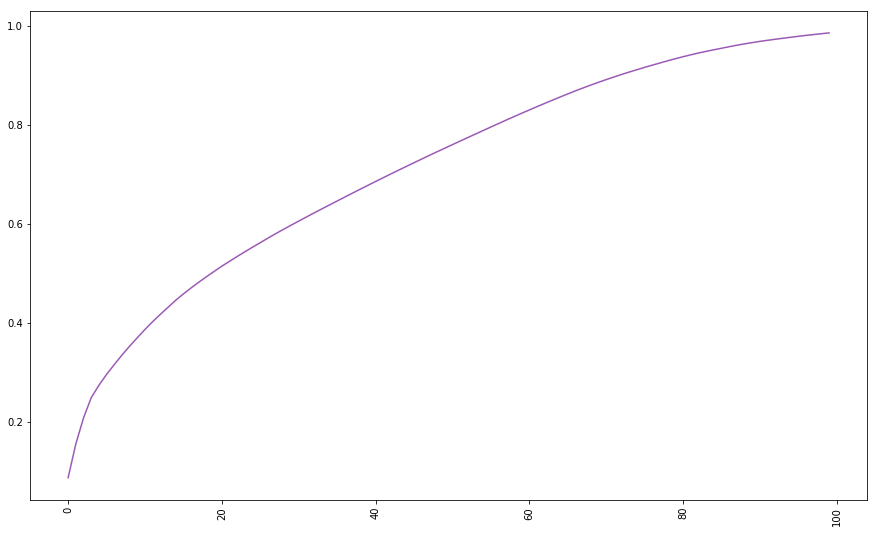

In [354]:
dimensions = dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca.components_)+1)]
# PCA components
components = pd.DataFrame(np.round(pca.components_, 4), columns = df_dummies_.columns)
components.index = dimensions
ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance'])
variance_ratios.index = dimensions

#plt.subplots(figsize = (15,9))
plt.figure(figsize =(15,9))
plt.plot(np.cumsum(variance_ratios.reset_index(drop = True)))
plt.xticks(rotation = 90)
plt.show()

In [0]:
# Re-apply PCA to the data while selecting for number of components to retain.

# Apply PCA to the data.
pca = PCA(n_components = 80)
pca_df = pca.fit_transform(df_dummies_normalised)


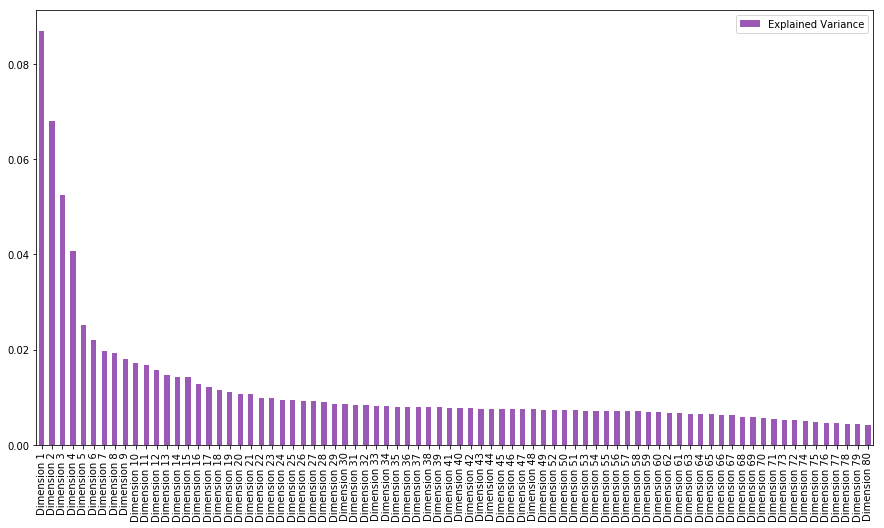

In [356]:
# Investigate the variance accounted for by each principal component.
# Dimension indexing
dimensions = dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca.components_)+1)]

# PCA components
components = pd.DataFrame(np.round(pca.components_, 4), columns = df_dummies_.columns)
components.index = dimensions

# PCA explained variance
ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance'])
variance_ratios.index = dimensions
variance_ratios.sort_values(by = 'Explained Variance',inplace=True,ascending=False)

variance_ratios.plot(kind='bar',figsize = (15,8))
plt.show()

### Discussion 2.2: Perform Dimensionality Reduction

We ran the pca using 100 components and drew the cumulative plot for the explained variance. In order to reduce the dimensionality we have to select the right number of components that explains most variance. We see from the chart that 80 components seems like a good cut off after which line starts to taper off and it explains >90% of the variance.

Using the 80 components, I run the pca again to plot the explained variance by each principal component. We can see that first 5 explains a lot of the variance followed by 6-16 components and then it begins to taper off into all the 80 components.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [357]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

def print_weights(n):
    '''
    n: number of principal component
    '''
    components = pd.DataFrame(np.round(pca.components_[n - 1: n], 4), columns = df_dummies_.keys())
    components.index = ['weights']
    components = components.sort_values(by = 'weights', axis = 1, ascending=False)
    components = components.T
    print(components)
    return components

_1st_component = print_weights(1)

                           weights
FINANZ_SPARER               0.2481
SEMIO_PFLICHT               0.2076
SEMIO_REL                   0.2076
pj_decade__90s              0.2029
SEMIO_TRADV                 0.1985
FINANZ_UNAUFFAELLIGER       0.1911
FINANZ_ANLEGER              0.1905
FINANZTYP_1                 0.1812
SEMIO_RAT                   0.1753
LP_STATUS_FEIN_2.0          0.1546
SEMIO_KULT                  0.1452
SEMIO_MAT                   0.1301
LP_STATUS_GROB_1.0          0.1298
ZABEOTYP_5                  0.1297
SEMIO_FAM                   0.1258
HH_EINKOMMEN_SCORE          0.1135
ZABEOTYP_4                  0.1033
pj_mainstream__mainstream   0.0932
GREEN_AVANTGARDE_0          0.0884
GFK_URLAUBERTYP_12.0        0.0749
ONLINE_AFFINITAET           0.0730
FINANZTYP_4                 0.0712
NATIONALITAET_KZ_2.0        0.0663
CAMEO_DEUG_2015_9           0.0617
ORTSGR_KLS9                 0.0587
SEMIO_SOZ                   0.0577
NATIONALITAET_KZ_3.0        0.0571
EWDICHTE            

In [358]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

_2nd_component = print_weights(2)

                           weights
HH_EINKOMMEN_SCORE          0.2106
FINANZ_HAUSBAUER            0.2091
LP_STATUS_GROB_1.0          0.1896
LP_STATUS_FEIN_1.0          0.1710
GREEN_AVANTGARDE_0          0.1597
SEMIO_KAEM                  0.1557
pj_mainstream__mainstream   0.1483
ZABEOTYP_3                  0.1427
SEMIO_KRIT                  0.1405
SEMIO_ERL                   0.1387
LP_FAMILIE_FEIN_1.0         0.1379
LP_FAMILIE_GROB_1.0         0.1379
ORTSGR_KLS9                 0.1369
ANREDE_KZ_2                 0.1359
EWDICHTE                    0.1354
ANZ_HAUSHALTE_AKTIV         0.1227
ARBEIT                      0.1171
SEMIO_DOM                   0.1171
RELAT_AB                    0.1035
CAMEO_DEUG_2015_9           0.0935
CAMEO_DEUG_2015_8           0.0910
ALTERSKATEGORIE_GROB        0.0780
RETOURTYP_BK_S              0.0746
FINANZ_VORSORGER            0.0662
GEBAEUDETYP_3.0             0.0658
SHOPPER_TYP_2.0             0.0626
OST_WEST_KZ_O               0.0575
SEMIO_LUST          

In [359]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

_3rd_component = print_weights(3)

                       weights
ANREDE_KZ_1             0.3110
SEMIO_VERT              0.2722
SEMIO_FAM               0.2301
SEMIO_SOZ               0.2266
SEMIO_KULT              0.2144
FINANZTYP_5             0.1391
LP_STATUS_FEIN_1.0      0.1182
RETOURTYP_BK_S          0.1093
ORTSGR_KLS9             0.1090
EWDICHTE                0.1074
SHOPPER_TYP_0.0         0.0932
SEMIO_REL               0.0886
LP_FAMILIE_FEIN_1.0     0.0828
LP_FAMILIE_GROB_1.0     0.0828
ARBEIT                  0.0815
ANZ_HAUSHALTE_AKTIV     0.0755
RELAT_AB                0.0751
LP_STATUS_GROB_1.0      0.0739
HH_EINKOMMEN_SCORE      0.0738
ZABEOTYP_6              0.0716
SEMIO_MAT               0.0664
FINANZ_VORSORGER        0.0643
CAMEO_DEUG_2015_9       0.0639
GEBAEUDETYP_3.0         0.0582
FINANZ_MINIMALIST       0.0580
CAMEO_DEUG_2015_8       0.0505
LP_STATUS_FEIN_3.0      0.0505
SHOPPER_TYP_1.0         0.0454
GFK_URLAUBERTYP_4.0     0.0452
ALTERSKATEGORIE_GROB    0.0443
...                        ...
LP_STATU

### Discussion 2.3: Interpret Principal Components

> 1st component : **Personal level features: *Age* and *Financial topology***
* ALTERSKATEGORIE_GROB        0.2257
* FINANZ_VORSORGER            0.2218
* FINANZ_MINIMALIST           0.2166
* FINANZ_SPARER              -0.2566

> 2nd component: **Home Location, Home ownership and # Family Houses**
* FINANZ_HAUSBAUER            0.2103
* EWDICHTE                    0.1947
* KBA05_GBZ                  -0.2000
* PLZ8_ANTG1                 -0.2129

> 3rd component: **Personality typology and Gender**
* SEMIO_VERT                  0.3101
* SEMIO_SOZ                   0.2796
* SEMIO_KULT                  0.2734
* ANREDE_KZ_2                -0.2816
* SEMIO_KRIT                 -0.2835
* SEMIO_KAEM                 -0.2950


We observe in the first component that it represents `personal info` and `financial` features, we observe a positive correlation with Age and Financial disposition. However, we can also see that Financial_Sparer ie. money-saver seem to be negatively correlated which makes sense. We would expect as one ages one becomes a better saver of money(here 1 means very-high and 5 means very low).

In the 2nd component is more centred around `home ownership` and the `home location` and `number of homes`. It is positively correlated with density of households and home ownership and negatively correlated with number of building in microcell and family house in a specific region. Thus this needs further investigation.

In the 3rd component `SEMIO_KRIT :critical-minded` and `SEMIO_KAEM: combative attitude` is negatively correlated with persoanlity typology of social and cultural people and we also see `ANREDE_KZ_2` which represents female is also negatively correlated with critical and combative attitude, I am not sure what I am to make of that :)

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [0]:
from sklearn.cluster import KMeans
# Over a number of different cluster counts...
    # run k-means clustering on the data and...
    # compute the average within-cluster distances.    

def get_kmeans_score(data, center):
    kmeans = KMeans(n_clusters=center,n_jobs = -1)
    model = kmeans.fit(data)
    score = np.abs(model.score(data))
    return score

Text(0.5, 1.0, 'SSE vs. K')

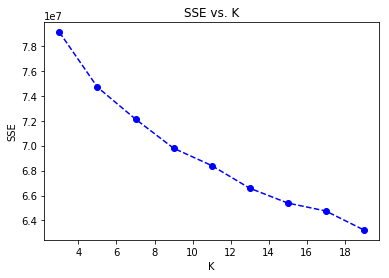

In [0]:
scores = []
centers = list(range(3,20,2))
for center in centers:
    scores.append(get_kmeans_score(pca_df, center))

plt.plot(centers, scores, linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('SSE');
plt.title('SSE vs. K')


In [0]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
kmeans_ = KMeans(n_clusters=15,n_jobs = -1,verbose=1)
kmeans_.fit(pca_df)
preds_azdias = kmeans_.predict(pca_df)

### Discussion 3.1: Apply Clustering to General Population

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding clustering. Into how many clusters have you decided to segment the population?)

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [362]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.
customers = pd.read_csv('/content/drive/My Drive/DSND/projects/p3_customer_segmentation/Udacity_CUSTOMERS_Subset.csv', sep = ';')#reading it again for ease
customers = clean_data(customers)
customers= scaler.transform(imputer_.transform(customers))
customers_pca = pca.transform(customers)
preds_customers = kmeans_.predict(customers_pca)

allOK
allOK


### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [363]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
print(np.bincount(preds_customers))
print(np.bincount(preds_azdias))
#pd.Series(pred_customers).value_counts()

[     0 117429      0      0      0    127      0      0      0  18480]
[ 32995  92579  77840  62704  90147  56435   6471  34408 107860  23329
  71892  17416   4645  69019  22066]


In [0]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?



In [0]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?



### Discussion 3.3: Compare Customer Data to Demographics Data

(Double-click this cell and replace this text with your own text, reporting findings and conclusions from the clustering analysis. Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?)

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.